In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
X_BOUNDARIES = [0, 11]
Y_BOUNDARIES = [0, 11]
ITERATIONS_NUM = 50

# Вспомогательные функции
def function(values):
  x = values[0]
  y = values[1]
  return (np.sin(y) * np.e ** ((1 - np.cos(x)) ** 2) + 
         np.cos(x) * np.e ** ((1 - np.sin(y)) ** 2) + (x - y) ** 2)

def count_reflected(x, y, alpha):
  return (1 + alpha) * x - alpha * y

def count_extended(x, y, gamma):
  return (1 - gamma) * x + gamma * y

def count_shrunk(x, y, beta):
  return (1 - beta) * x + beta * y

def count_center_of_mass(values):
  return ((values[:2].sum(axis=0)) / 2)[1:]

def check_boundaries(values):
  for i in range(2):
    values[i] = values[i] if values[i] <= 11 else 11
    values[i] = values[i] if values[i] >= 0  else 0
  return values

__Сама реализация метода Нелдера - Мида__:

In [91]:
# Реализация метода Нелдера - Мида
def Nelder_Mead_method(x_values, y_values, alpha=1, beta=0.5, gamma=2, ):
    # Считаем значение функции в начальных точках
    f_values = []
    for i in range(3):
      f_values.append([function([x_values[i], y_values[i]]), x_values[i], y_values[i]])
    f_values = np.array(f_values)

    # Для построения графика
    coordinates = []
    coordinates.append(f_values)

    for iteration in range(ITERATIONS_NUM):
      # Сортируем точки, порядок в массиве: f_l, f_g, f_h, т.е. от наименьшего к наибольшему
      f_values = f_values[f_values[:,0].argsort()]

      # Ищем центр тяжести всех точек, кроме точки с наибольшим значением функции
      center_of_mass = count_center_of_mass(f_values)

      # "Отражение"
      x_reflected = count_reflected(center_of_mass, f_values[2][1:], alpha)
      x_reflected = check_boundaries(x_reflected)
      f_reflected = function(x_reflected)
    
      # Ищем место f_reflected в ряду f_h, f_g, f_l
      if f_reflected < f_values[0][0]:
        # Растяжение
        x_extended = count_extended(center_of_mass, x_reflected, gamma)
        x_extended = check_boundaries(x_extended)
        f_extended = function(x_extended)
        f_values[2] = ([f_extended, x_extended[0], x_extended[1]] 
                       if f_extended < f_reflected 
                       else [f_reflected, x_reflected[0], x_reflected[1]])
      elif f_values[0][0] < f_reflected and f_reflected < f_values[1][0]:
        f_values[2] = [f_reflected, x_reflected[0], x_reflected[1]]
      else:
        if f_values[1][0] < f_reflected and f_reflected < f_values[2][0]:
          tmp = f_values[2]
          f_values[2] = [f_reflected, x_reflected[0], x_reflected[1]]
          f_reflected, x_reflected[0], x_reflected[1] = tmp

        # После действий выше порядок следующий: f_l <= f_g <= f_h <= f_r
        # Сжатие
        x_shrunk = count_shrunk(center_of_mass, f_values[2][0], beta)
        x_shrunk = check_boundaries(x_shrunk)
        f_shrunk = function(x_shrunk)
        if f_shrunk < f_values[2][0]:
          f_values[2] = [f_shrunk, x_shrunk[0], x_shrunk[1]]
        else:
          for i in range(3):
            f_values[i] = f_values[0] + (f_values[i] - f_values[0]) / 2
      coordinates.append(f_values)
    return coordinates

In [103]:
# Вспомогательные функции для построения графиков
def build_result(result, ax, title):
  for i in range(result.shape[0]):
    x = result[i][:, 1]
    x = np.append(x, x[0])
    y = result[i][:, 2]
    y = np.append(y, y[0])
    color = 'red' if i % 2 == 0 else 'blue'
    ax.plot(x, y, color)
  ax.scatter(result[0][:, 1], result[0][:, 2], alpha=1, color='red')
  ax.set_title(title)
  ax.set_xlabel("x - координата")
  ax.set_ylabel("y - координата")
  return ax

def build_function(x, y, ax1, ax2):
  x_grid, y_grid = np.meshgrid(x, y)
  z = (np.sin(y_grid) * np.e ** ((1 - np.cos(x_grid)) ** 2) + 
       np.cos(x_grid) * np.e ** ((1 - np.sin(y_grid)) ** 2) + 
       (x_grid - y_grid) ** 2)

  colors = sns.color_palette("Blues")
  ax1.contourf(x_grid, y_grid, z, colors=colors)
  ax2.contourf(x_grid, y_grid, z, colors=colors)
  return [ax1, ax2]

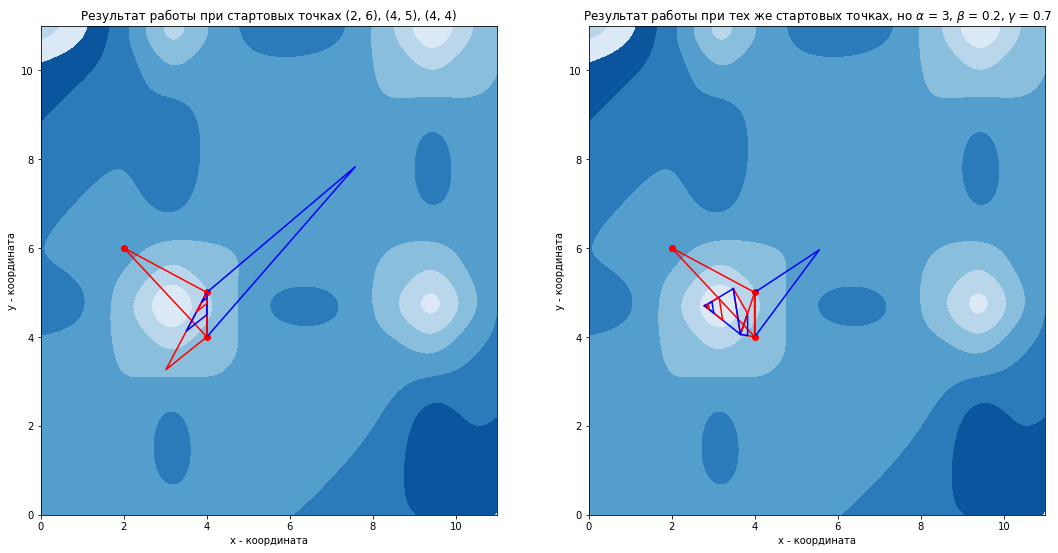

In [104]:
result = np.array(Nelder_Mead_method(x_values=[2, 4, 4], y_values=[6, 5, 4]))
# Зафиксируем набор начальных точек и попробуем поизменять гиперпараметры
result_with_different_params = np.array(Nelder_Mead_method(x_values=[2, 4, 4], 
                                                           y_values=[6, 5, 4], 
                                                           alpha=3, beta=0.2, 
                                                           gamma=7))

# Для наглядности построим contour-plot для исследуемой функции 
x = np.linspace(0, 11, 1000)
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1, ax2 = build_function(x, x, ax1, ax2)

# Посмотрим, как и куда сходится наш метод в первом случае
ax1 = build_result(result, ax1, 
                  "Результат работы при стартовых точках (2, 6), (4, 5), (4, 4)")

# И что с ним будет, если изменить гиперпараметры
ax2 = build_result(result_with_different_params, ax2, 
                   "Результат работы при тех же стартовых точках, но $\\alpha$ = 3, $\\beta$ = 0.2, $\\gamma$ = 0.7")
plt.show()

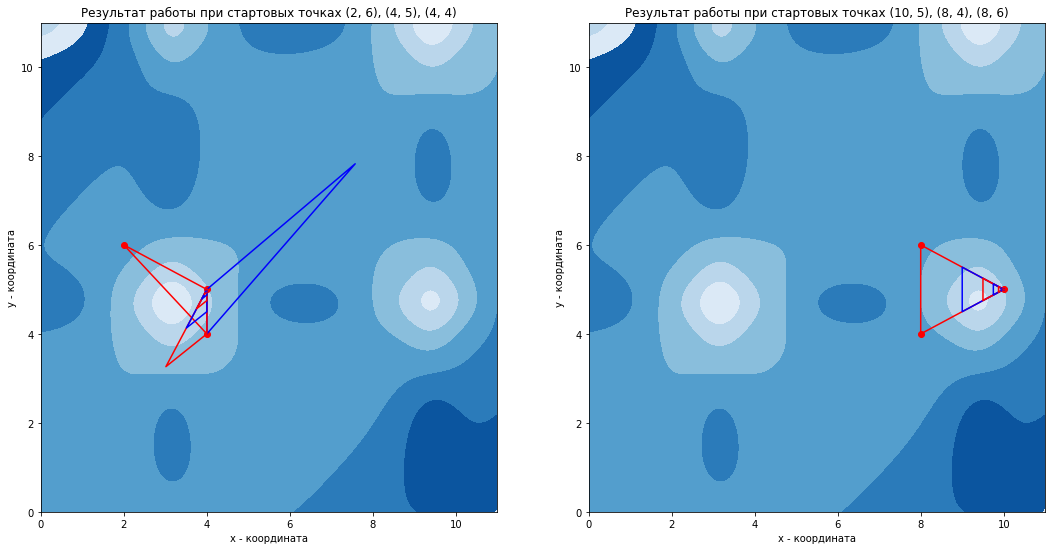

In [105]:
# Выберем другие начальные точки и посмотрим, к какому значению сойдется на этот раз
result = np.array(Nelder_Mead_method(x_values=[2, 4, 4], y_values=[6, 5, 4]))
result_with_different_start = np.array(Nelder_Mead_method(x_values=[10, 8, 8], 
                                                          y_values=[5, 4, 6]))

# Для наглядности построим contour-plot для исследуемой функции 
x = np.linspace(0, 11, 1000)
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1, ax2 = build_function(x, x, ax1, ax2)

# Посмотрим, как и куда сходится наш метод в первом случае
ax1 = build_result(result, ax1, 
                  "Результат работы при стартовых точках (2, 6), (4, 5), (4, 4)")

# И что с ним будет, если изменить гиперпараметры
ax2 = build_result(result_with_different_start, ax2, 
                   "Результат работы при стартовых точках (10, 5), (8, 4), (8, 6)")
plt.show()

__Вывод__: видим, что выбор стартовых точек и выбор гиперпараметров сильно влияют на результат работы метода.